### K-means spherical clustering
Some functions of this code is based on work derived from Dan Stowell. Will put in the doc-string as necessary.

His work is from here: https://core.ac.uk/reader/30341728 and code is located here https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt

#### Outline of work
##### Preprocessing step
- Resample to standard 44.1kHz
- Spectrogram (?)
- Calculate Mel spectrogram for each file (frame size of 1024 frames with Hamming windowing and no overlap)
- High-pass filtering (filter spectral energy below 500 Hz to reduce environmental noise)
- RMS normalization
- Spectral median noise reduction
- Normalize and PCA-whiten the data: https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt

##### Classification
- Apply spherical k-means clustering
- Use random forest classifier on feature data (from scikit-learn)

In [ ]:
import os 
import pydub
from pydub import AudioSegment
from scipy.io import wavfile
import samplerate
import librosa
import aasi_filters as filters

#### Preprocessing Step
- Functions and implementation included in this section

In [1]:
def read_mp3(f, normalized=False):
    """
    Inputs: MP3 to numpy array, f = filename
    Output: a.frame_rate (sampling rate)
    """
    a = pydub.AudioSegment.from_file(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return np.float32(y) / 2**15, a.frame_rate
    else:
        return y, a.frame_rate

def resample(filename, des_sr=44100): 
    """
    filename = name of desired file
    data = input data from audio file
    des_sr = desired sampling rate in Hz
    """
    if filename.endswith(".mp3") or filename.endswith(".MP3"): 
        data, sr = read_mp3(filename)
        data = samplerate.resample(data, des_sr/sr, 'sinc_best')
    elif filename.endswith(".wav") or filename.endswith(".WAV"): 
        sr, data = wavfile.read(filepath)
        data = samplerate.resample(data,des_sr /sr, 'sinc_best')
    else: 
        print("Not a valid file type (not .wav or .mp3)")
        pass 
        
    return data, des_sr

def make_mel_spectrogram(input_data, sr, n_fft = 1024): 
    """
    input_data (array): input array from a file 
    sr = sampling rate (Hz)
    """
    # TODO: figure out Hamming windowing and no overlap
    output = librosa.feature.melspectrogram(y=input_data, sr=sr)
    return output

def high_pass_filter(data, freq_cutoff=500, sr): 
    """
    data (numpy array): data of the desired file
    freq_cutoff: frequency cut off (Hz) 
    sr: sample rate of the file
    
    """
    sosfilter = filters.design_highpass_butter_filter(fcutoff, order, samplerate, sos=True)
    filt_data_sos = filters.filter(data, sosfilter, stereo=is_stereo)
    #filters.plot_specgrams(data, filt_data_sos, samplerate, stereo=is_stereo)
    
    return filt_data_sos

def RMS_normalize(): 
    """
    
    """
    
    

In [5]:
def plot_spectrogram(samplerate, shorter_clips, clip_index, separate_channels=False):
    left_channel = shorter_clips[clip_index][:, 0]
    right_channel = shorter_clips[clip_index][:, 1]
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Clip #%d (Left Channel)' % clip_index)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Clip #%d (Right Channel)' % clip_index)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Clip #%d' % clip_index)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
    
def plot_spectrogram_of_cluster(samplerate, shorter_clips, cluster_i, clusters, separate_channels=False):
    clip_indexes = get_clip_indexes(cluster_i, clusters)
    
    left_channel = shorter_clips[clip_indexes[0]][:, 0]
    right_channel = shorter_clips[clip_indexes[0]][:, 1]
    
    for i in range(1, len(clip_indexes)):
        left_channel = np.append(left_channel, shorter_clips[clip_indexes[i]][:, 0])
        right_channel = np.append(right_channel, shorter_clips[clip_indexes[i]][:, 1])
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Cluster #%d (Left Channel)' % cluster_i)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Cluster #%d (Right Channel)' % cluster_i)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Cluster #%d' % cluster_i)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()

## Pre-processing Step 
- Perform Mel spectra energy on data
- Normalize and PCA-whiten the data
- Apply spherical k-means clustering

In [6]:
def normalize_and_whiten(input_matrix, bias=1e-8):
    "Edited from: https://dfzljdn9uc3pi.cloudfront.net/2014/488/1/oskmeans.py.txt" 
    
    # Normalize Data 
    mean = np.mean(input_matrix)
    normdata = input_matrix - mean
    
    # PCA Whitening
    # this snippet is based on an example by Patrick Mineault
    cov = np.dot(normdata.T, normdata) / len(normdata) # covariance matrix
    eigs, eigv = np.linalg.eigh(cov) # docs say the eigenvalues are NOT NECESSARILY ORDERED, but this seems to be the case in practice...
    print("  computing number of components to retain %.2f of the variance..." % retain)
    
    d, V = np.linalg.eigh(Xcov)
    D = np.diag(1. / np.sqrt(d+bias)) #need a small factor so small eigenvalues do not get overamplified
    W = np.dot(np.dot(V, D), V.T)
    X_white = np.dot(X, W)
    
    return X_white

# Feature Extraction

In [36]:
samplerate = 44100
def extract_features(shorter_clips, mfcc_only=False, mono=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
#         print("clip", clip)
        if mono == False:
            clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate, winlen=0.023, nfft = 1024).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)

print(len(mfcc_clips))
print(len(mfcc_clips[0]))
# mfcc_clips = extract_features(shorter_clips, mfcc_only=True, mono=True)
#all_feat_clips = extract_features(shorter_clips)


Extracting features for each of the 14 audio clips
done
14
12987


In [43]:
# data_matrix = np.vstack(mfcc_clips)

pca = PCA(n_components=2, random_state=1, whiten=True)
# pca.fit(data_matrix)
whitened = pca.fit(mfcc_clips)

X = whitened.singular_values_
# array.reshape(-1, 1)
# pca.fit(mfcc_clips)

In [44]:
# from sklearn.externals.joblib import Parallel
n_clusters = 3

clusters = SphericalKMeans(n_clusters).fit_predict(X)
print(clusters)

ValueError: Expected 2D array, got 1D array instead:
array=[3818.15792346 2700.14442065].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Clustering
Graph elbow method and visualization of clusters

In [234]:
dist = 1 - cosine_similarity(mfcc_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

X = pos

In [ ]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [134]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20, savepath=''):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.1, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    
    if savepath != '':
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

#### Choose number of clusters
Note the the number of clusters needs to be less than the length of mfcc_clips

In [236]:
print(len(mfcc_clips))

1337


In [237]:
# Chose 134 from the number of bird species in the XenoCanto data
n_clusters = 134

# Fit clustering model
clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)

In [ ]:
# savepath = '/Volumes/Elements/dendrogram'
plt.savefig(savepath, dpi=200, bbox_inches="tight")

In [ ]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(mfcc_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True, savepath='/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/tsne.png')

# Cluster Interpretation

In [217]:
# Prints: (Cluster number, count of clips in cluster)
Counter(clusters).most_common()

[(1, 6), (0, 5), (2, 3)]

In [218]:
play_random_clip_in_cluster(6, clusters) # Play random clip in a cluster

ValueError: empty range for randrange() (0,0, 0)

In [139]:
sd.stop() # Stop playing

In [140]:
# Can assign a label to each cluster here
#cluster_names = ['quiet', 'loud', 'quiet', 'rain', 'birds', 'crickets', 'birds', 'quiet', 'quiet', 'loud']

In [219]:
play_clip(36) 

IndexError: list index out of range

## Save clusters of audio files

In [79]:
dirname = '/Volumes/Elements/Test/Clusters/'
# dirname = '/Volumes/Elements/Test/Clusters/'

for i in range(len(np.unique(clusters))):
    os.mkdir(dirname + 'cluster_%d' % i)
    for j in get_clip_indexes(i, clusters):
        save_clip(dirname + 'cluster_%d/%s' % (i, file_names[j]), shorter_clips[j])

In [220]:
print(len(np.unique(clusters)))
print(np.unique(clusters))
print(get_clip_indexes(i, clusters))
print(len(clusters))
print(len(file_names))

3
[0 1 2]
[0, 1, 2]
14
14


## Analyze clusters 
Find the total number of bird species in cluster and also the list of dictionary of each file name corresponding to each cluster number

In [238]:
num_bird_species = []
cluster_list_ordered = []

for i in range(len(np.unique(clusters))): 
    cluster_set = set()
    for j in get_clip_indexes(i, clusters):
        cluster_list_ordered.append(i)
        bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
#         print(bird_species)
#         print(type(bird_species))
        cluster_set.add(bird_species)
    num_bird_species.append(len(cluster_set))
    print(cluster_set)

print(file_names)
print(cluster_list_ordered)
# print(num_bird_species)        

{'Yellow Tyrannulet - Capsiempis flaveola flaveola_', 'Paint-billed Crake - Neocrex erythrops'}
{'Greyish Saltator - Saltator coerulescens', 'Riparian Antbird - Cercomacroides fuscicauda', 'Speckled Chachalaca - Ortalis guttata', 'Chestnut-headed Crake - Anurolimnas castaneiceps'}
{'Mouse-colored Tyrannulet - Phaeomyias murina wagae'}
{'Tropical Gnatcatcher - Polioptila plumbea parvirostris', 'Mato Grosso Swift - Chaetura viridipennis', 'Bright-rumped Attila - Attila spadiceus', 'Rusty-fronted Tody-Flycatcher - Poecilotriccus latirostris', 'Greyish Saltator - Saltator coerulescens', 'Black-faced Cotinga - Conioptilon mcilhennyi'}
{'Yellow-breasted Warbling Antbird - Hypocnemis subflava', 'Spot-breasted Woodpecker - Colaptes punctigula', 'Chestnut-bellied Seed Finch - Oryzoborus angolensis'}
{'Chattering Gnatwren - Ramphocaenus sticturus obscurus', 'Sunbittern - Eurypyga helias helias', 'Sulphury Flycatcher - Tyrannopsis sulphurea'}
{'Stripe-chested Antwren - Myrmotherula longicauda', '

134
Average number of birds over clusters: 2.1492537313432836


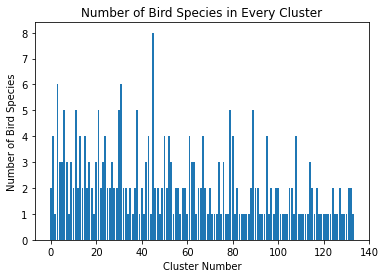

In [240]:
# Number of Bird Species in Every Cluster
print(len(num_bird_species))
cluster_num = range(0,len(num_bird_species))

x = cluster_num 
y = num_bird_species

# Add title, axes
plt.bar(x,y)
plt.title('Number of Bird Species in Every Cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Bird Species')

average_num_birds = sum(num_bird_species)/len(num_bird_species)
print("Average number of birds over clusters:", average_num_birds)

In [158]:
### Plot average number of birds over clusters for clusters ranging from 1 to 134

list_num_of_clusters = []
list_of_average_num_birds = []

for n in range(1,130,5):
    list_num_of_clusters.append(n)
    clusters = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit_predict(mfcc_clips)
    num_bird_species = []

    for i in range(len(np.unique(clusters))): 
        cluster_set = set()
        for j in get_clip_indexes(i, clusters):
            
            bird_species = os.path.splitext(file_names[j])[0].split("-",1)[1].strip()
    #         print(bird_species)
    #         print(type(bird_species))
            cluster_set.add(bird_species)
        num_bird_species.append(len(cluster_set))
            
    average_num_bird_species = sum(num_bird_species)/len(num_bird_species)
    list_of_average_num_birds.append(average_num_bird_species)
    
#     print(list_num_of_clusters)
#     print(list_of_average_num_birds)
    
    

[1]
[122.0]
[1, 6]
[122.0, 30.333333333333332]
[1, 6, 11]
[122.0, 30.333333333333332, 17.818181818181817]
[1, 6, 11, 16]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875]
[1, 6, 11, 16, 21]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619]
[1, 6, 11, 16, 21, 26]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619, 8.307692307692308]
[1, 6, 11, 16, 21, 26, 31]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619, 8.307692307692308, 7.096774193548387]
[1, 6, 11, 16, 21, 26, 31, 36]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619, 8.307692307692308, 7.096774193548387, 6.277777777777778]
[1, 6, 11, 16, 21, 26, 31, 36, 41]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619, 8.307692307692308, 7.096774193548387, 6.277777777777778, 5.658536585365853]
[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
[122.0, 30.333333333333332, 17.818181818181817, 13.1875, 10.19047619047619, 8.

KeyboardInterrupt: 

In [148]:
# Plot spectrogram of all clips in a cluster appended together
plot_spectrogram_of_cluster(samplerate, shorter_clips, 7, clusters, separate_channels=False)

IndexError: too many indices for array

## Save as .csv

In [45]:
## pandas dataframe ## 
import pandas as pd 

bird_species = {
    'File name': file_names,
    'Time in clip (seconds)': timestamp,
    'Cluster number': cluster_list_ordered
}

df = pd.DataFrame(bird_species, columns = ['File name', 'Time in clip (seconds)', 'Cluster number'])

df.to_csv(r'/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/export_dataframe.csv',index = False, header=True)
            
print(head(df))
# filename list 
# start and end time in the clip analyzed
# sample rate 
# cluster number


NameError: name 'cluster_list_ordered' is not defined

# Visualization

In [ ]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [ ]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

In [ ]:
def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))

### (Optional) testing convert_mp3_to_wav function with one file
This is an extra step that I made to quickly check and troubleshoot the convert_mp3_to_wav function

In [ ]:
dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
file_path = dir_path + 'XC431125 - Rufous Twistwing - Cnipodectes superrufus.mp3'
# file_path = dir_path + 'XC91323 - White-eyed Parakeet - Psittacara leucophthalmus.mp3'

x, fs = convert_mp3_to_wav(file_path, overwrite=True)

In [ ]:
# Graphs to sanity check output of load_audio with online mp3 to wav converter 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x)

print(x.shape)

# This file is from a random mp3 to wav convert I found here
# https://online-audio-converter.com/ and then downloaded on Desktop
check_dir_path = '/Users/yoo-jin/Desktop/XC431125 - Rufous Twistwing - Cnipodectes superrufus.wav'
x_test, fs_test = sf.read(check_dir_path)

x_test = np.mean(x_test, axis = 1) 
print(x_test.shape)

ax2.plot(x_test)


### Optional: For K-means clustsering 
The function, find_optimal_clusters is used to find the optimal number of clusters for K-means clustering. Take a look at this link for more information: https://hlab.stanford.edu/brian/number_of_clusters_.html.

In [ ]:
## TODO: plot.ly

def find_optimal_clusters(data, min_k, max_k): 
    iters= range(min_k, max_k+1, 2)
    
    sse = [] 
    for k in iters: 
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
    
#     import pandas as pd
#     sse_pct_diff = pd.Series(sse)
#     sse_pct_diff.pct_change()
#     print(sse_pct_diff)
    
    f, ax = plt.subplots(1,1)
    ax.plot(iters, sse, marker = 'o')
    ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     f.autofmt_xdate()
#     ax.set_xtickslabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Number of Clusters')
    
#     ax[0].plot(iters, sse, marker = 'o')
#     ax[0].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[0].set_ylabel('SSE')
#     ax[0].set_title('SSE by Number of Clusters')
    
#     ax[1].plot(iters, sse_pct_diff, marker = 'o')
#     ax[1].set_xlabel('Cluster Centers')
# #     ax.set_xticks(iters)
# #     f.autofmt_xdate()
# #     ax.set_xtickslabels(iters)
#     ax[1].set_ylabel('Percentage Change of SSE')
#     ax[1].set_title('Percentage Change of SSE by Number of Clusters')
    
    plt.tight_layout()

        
# Change the range here: 
find_optimal_clusters(X, 1, 150)

In [ ]:
# dir_path = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/'
dir_path = '/Volumes/Elements/Test/'
samplerate = None
wav_data = []
bird_names_and_lengths = []
num_files = 0

for file in glob.glob(os.path.join(dir_path, '*.mp3')):
#     print(file)
#     convert_mp3_to_wav(file, overwrite=True)
    num_files = num_files+1
    try: 
        data, rate = convert_mp3_to_wav(file, overwrite=True)
#         data = data.astype(int)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        clip_len = len(data) / samplerate
        
        # Input only bird species
        bird_species = file.split(' - ')[2][:-4].replace(' ', '_')
        bird_names_and_lengths.append([bird_species, clip_len])
#         print(file)
        
        # TO DO: deal with warning, don't suppress
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        warnings.filterwarnings("ignore", category=FutureWarning) 
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass
    
print(bird_names_and_lengths)
    
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

### Optional: list all bird species included in the file

In [ ]:
dir_path = '/Volumes/Elements/Test/'
list_of_species = []

for f in glob.glob(os.path.join(dir_path, '*.mp3')): 
    bird_name = os.path.splitext(f)[0].split(" - ", 1)[1].strip()
    if list_of_species == []: 
        list_of_species = [bird_name]
    elif bird_name in list_of_species: 
        pass 
    else: 
        list_of_species.append(bird_name)

print(list_of_species)
# print(len(list_of_species))

In [ ]:
# Get n-minute clips
# def split_into_minutes(wav_data, samplerate, n=1):
#     length_in_seconds = len(wav_data) / samplerate
#     length_in_minutes = length_in_seconds / 60
#     length_in_minutes = int(length_in_minutes / n)

#     cut_wav_data = wav_data[:-((len(wav_data)) % length_in_minutes)]
#     shorter_clips = np.split(cut_wav_data, length_in_minutes)
#     print('%d %d-minute clips' % (len(shorter_clips), n))
#     return shorter_clips

# Get n-second clips
def split_into_n_seconds(wav_data, wav_names_and_lengths, samplerate, n):
    """
    wav_data: numpy array of length equal to the length of the all audio files
    wav_names_and_lengths: list of list of length 2 where the first element is 
    the name of the bird species associated with the file and the second element
    is the length (in seconds) of the file
    samplerate: int (in Hz)
    n: (int) to divide the data into n-seconds 
    """
    
    # TODO: 
    # if n > 5: take like the first 5 seconds
    # if n < 2: ignore 
    # csv file: metadata of clips entered, cluster number with its filename
    # just have the names and don't save data
    
    file_names = []
    length_in_seconds = len(wav_data) / samplerate 
    print("length in seconds", length_in_seconds)
    
#     length_in_minutes = length_in_seconds / 60
#     print(length_in_minutes)
    
    # Rounding down    
    n_chunks = int(np.floor(length_in_seconds/n))
    print("n_chunks", n_chunks)
        
    try:
        second_clips = np.split(wav_data, n_chunks)
    except ValueError:
        cut_wav_data = wav_data[:-(len(wav_data) % n_chunks)]
        erased_amount = len(wav_data) % n_chunks
        erased_amount_s = erased_amount/samplerate
        shortest_wav_s = min([x[1] for x in wav_names_and_lengths])
        print([x[1] for x in wav_names_and_lengths])
        assert erased_amount_s < shortest_wav_s
        wav_names_and_lengths[-1][1] = wav_names_and_lengths[-1][1] - erased_amount_s
        # n = 1
        # wav_names_and_lengths = [['1.2s_wav', 1.2],...,['3.5s_wav', 3.5]]
        second_clips = np.split(cut_wav_data, n_chunks)
#         print("second_clips", second_clips)
        print("length of each array", [x.shape for x in second_clips])

    ### NAMING FILES ###
    
#     [['Trogon_curucui', 25.33877551020408], ['Hemitriccus_griseipectus', 14.78530612244898], 
#      ['Amazilia_lactea', 6.034285714285715], ['Myrmoborus_lophotes', 30.48], 
#      ['Jacamerops_aureus', 25.944013605442176], ['Tityra_cayana', 4.675918367346939], 
#      ['Synallaxis_cabanisi', 67.05632653061224]]
        
    ### PSEUDOCODE ###
    
#     length in seconds 174.31462585034015
#     n_chunks 11
    # 15.8 seconds
    num_of_seconds_in_chunk = length_in_seconds/n_chunks
        
    ### here ###
#     n_leftover = 0
#     filenames = []
#     i = 0
#     while i < len(wav_names_and_lengths)-1: 
#         if wav_names_and_lengths[i][1] < n:
#             n_leftover = 0
#             filenames.append(wav_names_and_lengths[i][0])
#             print("first case")
#             print("wav_names_and_lengths[i][1]", wav_names_and_lengths[i][1])
# #             filenames[i] = wav_names_and_lengths[i][0]
#             print("filenames", filenames)
#             print()
#             print("n_leftover", n_leftover)
#             n_leftover = n_leftover + wav_names_and_lengths[i][1]

#             while n_leftover < n:
#                 print("length of filenames", len(filenames))
#                 print("filenames", filenames)
#                 filenames[-1] += wav_names_and_lengths[i+1][0]
#                 n_leftover = n_leftover + wav_names_and_lengths[i+1][1]
#                 i = i +1
            
#         elif wav_names_and_lengths[i][1] == n: 
#             print("second case")
#             filenames.append(wav_names_and_lengths[i][0])
#             i = i + 1

#         else: #filename_and_len[i][1] > n: 
#             print("third case")
#             print("i", i)
#             print("filenames", filenames)
#             filenames.append(wav_names_and_lengths[i][0])
#             while wav_names_and_lengths[i][1] > n: 
#                 print("len(filenames)",len(filenames))
#                 print("filenames", filenames)
#                 wav_names_and_lengths[i][1] = wav_names_and_lengths[i][1] - n
#                 i = i + 1
    
#     raise NotImplementedError('finish me')

    i = 0
    amount_left = 0
    first_case_count = 0 

    while i < len(wav_names_and_lengths):
        if wav_names_and_lengths[i][1] >= num_of_seconds_in_chunk and amount_left == 0:  
            file_names.append(wav_names_and_lengths[i][0] + str(first_case_count))   
            wav_names_and_lengths[i][1] = wav_names_and_lengths[i][1] - num_of_seconds_in_chunk
            first_case_count+=1
        
        # create new clip and leave it unfinished
        elif wav_names_and_lengths[i][1] < num_of_seconds_in_chunk and amount_left == 0:  
            if i != len(wav_names_and_lengths)-1 :
                file_names.append(wav_names_and_lengths[i][0] + "_") 
            else: 
                file_names.append(wav_names_and_lengths[i][0]) 
            amount_left = num_of_seconds_in_chunk - wav_names_and_lengths[i][1]
            wav_names_and_lengths[i][1] = 0
            i = i +1
            
        # finish prev clip
        elif wav_names_and_lengths[i][1] >= amount_left and amount_left > 0:
            file_names[-1] += wav_names_and_lengths[i][0]
            wav_names_and_lengths[i][1] -= amount_left
            amount_left = 0
            
        elif int(wav_names_and_lengths[i][1]) == 0:
#             print("Hits zero case")
#             print("i", i)
#             print("amount_left", amount_left)
#             print()
            i+=1
            
        elif wav_names_and_lengths[i][1] < amount_left and amount_left > 0: 
            if i == len(wav_names_and_lengths)-1:
                file_names[-1] += wav_names_and_lengths[i][0]
            else:  
                file_names[-1] += wav_names_and_lengths[i][0] + "_"
            amount_left = num_of_seconds_in_chunk - wav_names_and_lengths[i][1]
            wav_names_and_lengths[i][1] = 0
            i = i+1
            
    print('%d %d-second clips' % (len(second_clips), n))
    return second_clips, file_names

In [ ]:
print("shape of wav_data", len(wav_data))
print("sample rate", sr)
print("type of wav_data", type(wav_data))
print('sample rate = %d' % samplerate)
print(wav_data.shape)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)

In [83]:
# loop through all the cluster folders 
from os import listdir
from os.path import isfile, join

# dirname = '/Volumes/Elements/Madre_de_Dios_Xeno_Canto_Birdcalls/Clusters_XenoCanto/'
dirname = '/Volumes/Elements/Test/Clusters/'
directory_list = os.listdir(dirname)
# print(directory_list)
# make "find . -name ".DS_Store" -delete" in the terminal 

final_bird_list = []
num_bird_species = []

for d in directory_list: 
    path = dirname + d
    file_list = [f for f in os.listdir(path) if not f.startswith('.')]
    
    cluster_set = set()
    for f in file_list: 
#         print(f)
#         if not f.startswith('.'):
        cluster_set = cluster_set | find_bird_species_from_file_name(f)
#         print(f)
    
    num_bird_species.append(len(cluster_set))
    final_bird_list.append(num_bird_species)
        
# print(final_bird_list)
# print(cluster_set)
print(num_bird_species)

XC - White-lined Antbird - Myrmoborus lophotes

XC - White-lined Antbird - Myrmoborus lophotes

XC - White-lined Antbird - Myrmoborus lophotes

XC - Great Jacamar - Jacamerops aureus

XC - Great Jacamar - Jacamerops aureus

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Cabanis's Spinetail - Synallaxis cabanisi

XC - Blue-crowned Trogon - Trogon curucui

XC - Blue-crowned Trogon - Trogon curucui

XC - White-bellied Tody-Tyrant - Hemitriccus griseipectus

[2, 1, 2]
